## Imports & preparation

In [1]:
import scipy
import paths
import pickle
import numpy as np
import pandas as pd

# Import the Generator class
from bioverse.generator import Generator
from bioverse.survey import TransitSurvey
from bioverse.constants import CONST, DATA_DIR
# from bioverse import util

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
# %matplotlib osx
# %matplotlib inline

import plotstyle
plotstyle.styleplots()


%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 200
pd.options.display.max_columns = 80

figdir = '/Users/schlecker/repos/magmaocean/src/tex/figures/'
talkfigdir = '/Users/schlecker/talks/20221107_HabitableWorlds_Bioverse/figures/' 
paperdatadir = '/Users/schlecker/repos/magmaocean/src/data/'

## preparatory steps (to be done only once)

Read in Dorn & Lichtenberg 2021 Fig. 3b from plot line extractor

In [2]:
# from scipy.interpolate import interp1d
# from bioverse.constants import DATA_DIR

# wrr_grid = np.geomspace(1e-4, 3e-1, num=20)
# xy = {'wrr' : wrr_grid}

# for i, (mp, mp_flt) in enumerate(zip(['0p3', '0p8', '2p4', '6p7'], [0.3, 0.8, 2.4, 6.7])):
#     # read extracted csv file (from plot extraction tool)
#     df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b_extracted.csv', usecols=[2*i,2*i+1])
#     f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
#     xy[mp_flt] = f_xy(wrr_grid)
    
#     plt.plot(xy['wrr'], xy[mp_flt])
# plt.xscale('log')
# plt.xlabel('water mass fraction')
# plt.ylabel('Radius deviation')

# # pd.DataFrame(xy).to_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', index=False)

In [3]:
# # sanity-check the interpolation
# df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', )

# mass_grid = np.arange(0.3, 7., 0.1)

# for wrr in wrr_grid[::3]:
#     dr_wrr = df.iloc[(df['wrr'] - wrr).abs().argsort()[0], :][1:]
#     f_dr = interp1d(dr_wrr.index.to_numpy(dtype=float), dr_wrr.values, fill_value='extrapolate')
#     dr = f_dr(mass_grid)
#     plt.plot(mass_grid, dr, label = '{:.0e}'.format(wrr))

# # for i, mp_flt in enumerate([0.3, 0.8, 2.4, 6.7]):
#     # f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
#     # xy[mp_flt] = f_xy(wrr_grid)
#     # plt.plot(df['wrr'], df[str(mp_flt)])
    
# # plt.xscale('log')

# plt.xlabel('planet mass')
# plt.ylabel('Radius deviation')
# plt.legend(fontsize=12, loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
 

# Sample generation

## Generate stars and planets, inject magma oceans


Keep only small planets/low-mass planets, but above 0.1 M_Earth (Turbet+2020 covers only 0.1 to 2 Mearth). Don't consider "lava worlds" with extremely high instellation.

Set a generic detection bias: transit depth $\delta > 75$ ppm.

In [322]:
# Parameters of the analysis
# parameter_of_interest = 'rho'
parameter_of_interest = 'R'

def get_generator_args():
    """ define generator parameters"""
    # Parameters for star generation 
    stars_args = {
    # 'd_max' : 75,             # max. distance to stars in parsec
    'd_max' : 90,             # max. distance to stars in parsec
    'M_st_max' : 1.5,         # Maximum stellar mass to consider, in solar units.
    'M_G_max' : 11,           # Maximum gaia magnitude of stars
    'seed' : 42,              # seed for random number generators
    'lum_evo' : True          # luminosities from luminosity tracks (Baraffe et al. 1998), based on random ages? [SLOW?]
    } 

    # Parameters for planet generation and magma ocean model
    planets_args = {
    'transit_mode': True,      # Simulate only transiting planets
    'f_eta' : 1.,               # Occurrence rate scaling factor
    'R_min' : 0.75,             # minimum radius for Bergsten et al. planet generator
    'P_max' : 365.,             # maximum period for Bergsten et al. planet generator

    'mr_relation' : 'Zeng2016', # choice of mass-radius relationship

    'gh_increase' : True,       # wether or not to consider radius increase due to runaway greenhouse effect (Turbet+2020)
    'water_incorp' : True,      # wether or not to consider water incorporation in the melt of global magma oceans (Dorn & Lichtenberg 2021)
    'S_thresh' : 280.,          # threshold instellation for runaway greenhouse phase
    'wrr' : 0.005,              # water-to-rock ratio for Turbet+2020 model. Possible vals: 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05
    # 'wrr' : 0.05,              # water-to-rock ratio for Turbet+2020 model. Possible vals: 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05
    'f_rgh' : .8,               # fraction of planets with a runaway gh climate _within_ the runaway gh regime 
        
    'simplified' : False,       # increase the radii of all runaway greenhouse planets by the same fraction
    # 'diff_frac' : 0.48,       # fractional radius change in the simplified case.

    # detection bias and sample selection: Keep only small planets/low-mass planets, but above 0.1 M_Earth (Turbet+2020 covers only 0.1 to 2 Mearth). Don't consider "lava worlds" with extremely high instellation.
    # Set a generic detection bias: transit depth $\delta > 75$ ppm.
    'M_min' : 0.1,
    'M_max' : 2.,
    'S_max' : 2000.,            # max. instellation in W/m2
    'depth_min' : 75e-6         # min. transit depth
        
    # 'window' : 25               # window size of the rolling mean of radius/density
    }
    return stars_args, planets_args

def generate_generator(**kwargs):
    stars_args, planets_args = get_generator_args()
    g_args = stars_args | planets_args  
    for key, value in kwargs.items():
        g_args[key] = value
    g_transit = Generator(label=None)
    g_transit.insert_step('read_stars_Gaia') 
    g_transit.insert_step('create_planets_bergsten')
    g_transit.insert_step('assign_orbital_elements')
    g_transit.insert_step('impact_parameter')
    g_transit.insert_step('assign_mass')
    g_transit.insert_step('effective_values')
    g_transit.insert_step('magma_ocean')     # here we inject the magma oceans
    g_transit.insert_step('compute_transit_params')
    g_transit.insert_step('apply_bias')
    [g_transit.set_arg(key, val) for key, val in g_args.items()]
    return g_transit
    

In [323]:
%%time
# Create the first generator manually so we have stars and planets separated    
g_transit = Generator(label=None)
g_transit.insert_step('read_stars_Gaia') 
stars_args, planets_args = get_generator_args()
# # provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in stars_args.items()]

# # Insert a function to the generator that labels late M dwarfs, defining a stellar mass threshold Mst_threshold.
# # g_transit.insert_step(label_lateM)

# # the stellar sample alone can be extracted here:
stars = g_transit.generate() 
# # stars.to_pandas().M_st.hist()
# # plt.xlabel('M_star')

# # Generate planets
g_transit.insert_step('create_planets_bergsten')
g_transit.insert_step('assign_orbital_elements')
g_transit.insert_step('impact_parameter')
g_transit.insert_step('assign_mass')
g_transit.insert_step('effective_values')
g_transit.insert_step('magma_ocean')     # here we inject the magma oceans
g_transit.insert_step('compute_transit_params')
g_transit.insert_step('apply_bias')

# # provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in planets_args.items()]

# # save the generator
# # g_transit.save('transit_magmaocean')

# # show generator steps
# g_transit

sample = g_transit.generate()
# sample = sample.to_pandas()
# print("Generated a sample of {:d} planets including {:d} exo-Earth candidates.".format(len(sample), sample['EEC'].sum()))
print('Total number of planets: {}'.format(len(sample)))

Created a new Generator
Total number of planets: 496
CPU times: user 2min 29s, sys: 1.95 s, total: 2min 31s
Wall time: 2min 33s


## Test Bergsten et al. occurrence rates implementation

In [324]:
# # show sample in period-radius:
# yvar = parameter_of_interest

# sampledf = sample.to_pandas()
# early = sampledf[sampledf.M_st > 0.9].sample(500)
# late = sampledf[sampledf.M_st < 0.2].sample(500)

# fig, ax = plt.subplots(figsize=[10, 6])
# for sampledf, label in zip([early, late], ['early', 'late']):

#     ax.scatter(sampledf[sampledf.transiting==False].a_eff, sampledf[sampledf.transiting==False][yvar], s=5., alpha=.7, label=label)

#     # transiting planets
#     # ax.scatter(sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

#     # show differences in radius due to magma ocean
#     if yvar =='R':
#         X_coords= np.array([sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True].a_eff])
#         Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
#         ax.plot(X_coords, Y_coords, c='k', lw=1., alpha=.4, zorder=-1)

#         ax.set_ylabel('Radius [$R_\oplus$]')
#     elif yvar == 'rho':
#         ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]')

#     # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

#     ax.set_xlabel('Solar-equivalent semimajor axis [au]')
#     # ax.loglog()
#     ax.set_xscale('log')
#     ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                                   frameon=False, columnspacing=1.6)
#     # ax.set_ylim(0.5, 1.3)

#     print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

Plot different radii

avg radius change of runaway GH planets: +15 %
avg density change of runaway GH planets: -34 %


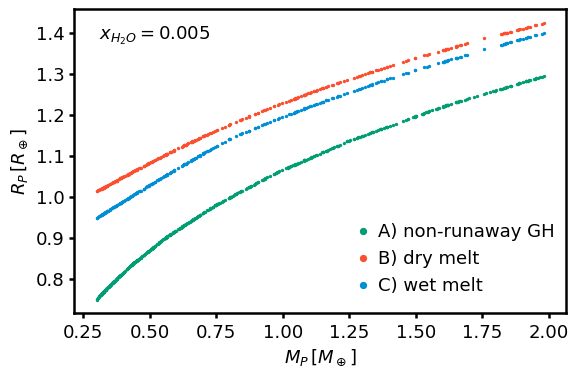

In [325]:
# check if M-R relation looks good:
dd = sample.to_pandas()
d = dd.sample(min([len(dd), 4000]))
mo = dd[dd.has_magmaocean].sample(min([len(dd[dd.has_magmaocean]), 4000]))

fig, ax = plt.subplots()
# plt.scatter(mo.M, mo.R_orig, s=1., label='original radius', c='gray')
# plt.scatter(mo.M, mo.R, s=1., label='new radius')
# plt.scatter(mo.M, mo.R - mo.R_orig, s=1., label='$\Delta R$', alpha=.4)

ax.scatter(d.M, d.R_orig, s=2., label='A) non-runaway GH', c='C0')
try:
    ax.scatter(mo.M, mo.R_steam, s=2., label='B) dry melt', c='C1')
except AttributeError:
    pass
ax.scatter(mo.M, mo.R, s=2., label='C) wet melt', c='C2')

ax.set_xlabel('$M_P \,[M_\oplus]$')
ax.set_ylabel('$R_P \,[R_\oplus]$')
ax.legend(loc='lower right', ncol=1, bbox_to_anchor=(1.01, 0.01),
                              frameon=False, columnspacing=1.6, markerscale=3)
ax.annotate('$x_{{H_2O}}= ${}'.format(planets_args['wrr']), xy=(0.05,.9), xycoords='axes fraction')

radius_change = np.average(mo.R/mo.R_orig) - 1
print('avg radius change of runaway GH planets: {:+.0f} %'.format(100*radius_change))
density_change = np.average(mo.rho/(CONST['rho_Earth']*mo.M/mo.R_orig**3)) - 1
print('avg density change of runaway GH planets: {:+.0f} %'.format(100*density_change))

In [326]:
# fig.savefig(figdir + 'radiuscomparison.pdf')
# fig.savefig(paths.static / 'radiuscomparison.pdf')

In [327]:
# # show sample in period-radius:

# from matplotlib.ticker import ScalarFormatter


# talk = False 
# if talk:
#     plt.style.use('dark_background')
# else:
#     plt.style.use('default')

# yvar = parameter_of_interest

# sampledf = sample.to_pandas()
# # fig, ax = plt.subplots(figsize=[10, 6])
# fig, ax = plt.subplots()
# ax.scatter(sampledf[sampledf.transiting==False].S_abs, sampledf[sampledf.transiting==False][yvar], s=1.5, c='dimgray',alpha=.5, label='synthetic planets')

# sampledf[sampledf.transiting==False].rho

# # transiting planets
# ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

# # show differences in radius due to magma ocean
# if yvar =='R':
#     X_coords= np.array([sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True].S_abs])
#     Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
#     ax.plot(X_coords, Y_coords, c='gray', lw=1.5, alpha=.5, zorder=-1)
    
#     for i in range(len(sampledf[sampledf.transiting==True])):
#         if Y_coords[1][i] != Y_coords[0][i]:
#             ax.annotate(
#               "",
#               xy=(X_coords[0][i], Y_coords[1][i]), xytext=(0, -1.),#xytext=(0., Y_coords[1][i]),
#               textcoords='offset points', ha='right', va='bottom',
#               bbox=dict(boxstyle='round,pad=0.5',  alpha=0.5),
#               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=.5, lw=1.5),
#             zorder = -9
#            )
    
#     ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
# elif yvar == 'rho':
#     ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# # ax.set_xlabel('Solar-equivalent semimajor axis [au]')
# ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# # ax.loglog()
# ax.set_xscale('log')
# ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
# plt.xlim(50., 2000.) 
# plt.ylim(1., 1.4)

# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

# print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

In [328]:
# fig.savefig('/Users/schlecker/repos/magmaocean/src/tex/figures/synthetic_population.pdf', bbox_inches='tight')
# fig.savefig(talkfigdir + 'instellation-radius_N32.png', bbox_inches='tight', dpi=600)

Same plot with only transiting planets

In [329]:
# talk = False 
# if talk:
#     plt.style.use('dark_background')

# yvar = parameter_of_interest
# sampledf = sample.to_pandas()

# # fig, ax = plt.subplots(figsize=[10, 6])
# fig, ax = plt.subplots()
# ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

# if yvar =='R':
#     ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
# elif yvar == 'rho':
#     ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# # ax.set_xlabel('Solar-equivalent semimajor axis [au]')
# ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# # ax.loglog()
# ax.set_xscale('log')
# ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
# plt.xlim(50., 2000.) 
# plt.ylim(1., 1.4)

# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

In [330]:
# fig.savefig(talkfigdir + 'instellation-radius_transiting.png', bbox_inches='tight', dpi=600)
# fig.savefig(talkfigdir + 'instellation-radius_N500.png', bbox_inches='tight', dpi=600)

## Explore radius-sma dependency
Let's have a look at the (effective) sma dependence of planets bearing magma oceans. Hypothesis tests are based on the average planet radius *outside* the threshold instellation S_thresh.

In [331]:
# from bioverse.hypothesis import magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 
# from bioverse.util import S2a_eff, a_eff2S
# from matplotlib.ticker import ScalarFormatter
# import scipy

# talk = False
# if talk:
#     plt.style.use('dark_background')

def binned_stats(df, x_param, y_param, bins, statistic='mean'):
    means, edges, n = scipy.stats.binned_statistic(df[x_param], df[y_param], 
                                             statistic=statistic, bins=bins)
    std = []
    for e_lo, e_hi in zip(edges[:-1], edges[1:]):
        std.append(np.std(df[(df[x_param] > e_lo) & (df[x_param] < e_hi)][y_param]))
    return means, edges, n, std

# # a_eff_grid = np.geomspace(0.05, 10., num=250)         # a_eff grid
# S_grid = np.linspace(50., 2000., 250)
# a_eff_grid = S2a_eff(S_grid)




# R_avg_out = np.average(sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])
# R_avg_in = np.average(sample['R'][sample['S_abs'] >= planets_args['S_thresh'] & sample['transiting']])

# rho_avg_out = np.average(CONST['rho_Earth']*sample['M'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']]/
                         # (sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])**3)
# rho_avg_in = np.average(CONST['rho_Earth']*sample['M'][sample['S_abs'] >= planets_args['S_thresh'] & sample['transiting']]/
                         # (sample['R'][sample['S_abs'] >= planets_args['S_thresh']& sample['transiting']])**3)


# P_magma = magma_ocean_hypo_step((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['radius_reduction'], R_avg), a_eff_grid)
# P_magma = magma_ocean_hypo_exp((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['lambda_a']), a_eff_grid)
    
# avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() # import avg_deltaR_deltaRho once here to avoid a lot of file I/O during hypothesis calls
# if parameter_of_interest == 'R':
#     P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], R_avg_out), a_eff_grid, 
#                                gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
#                                simplified=planets_args['simplified'], diff_frac=radius_change,
#                                parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
    
    
#     P0 = magma_ocean_f0(R_avg_out, a_eff_grid)
# elif parameter_of_interest == 'rho':
#     P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], rho_avg_out), a_eff_grid, diff_frac=density_change,
#                                parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
#     P0 = magma_ocean_f0(rho_avg_out, a_eff_grid)

# # backtransform from a_eff to S
# S_grid = a_eff2S(a_eff_grid)

# plt.plot(S_grid, P_magma, label='H$_\mathrm{magma ocean}$', lw=3)
# plt.plot(S_grid, P0, label='H$_0$')
# plt.xscale('log')

# # plt.xlabel('Solar-equivalent semimajor axis [au]',fontsize=15)
# plt.xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)

# if parameter_of_interest == 'R':
#     if talk:
#         plt.ylabel('avg. planet radius [R$_\oplus$]',fontsize=15)
#     else:
#         plt.ylabel('$<R_P>$',fontsize=15)
# elif parameter_of_interest == 'rho':
#     plt.ylabel('$<\\rho>$',fontsize=15)

# fig = plt.gcf()
# ax = plt.gca()
# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
    


N_transiting: 496


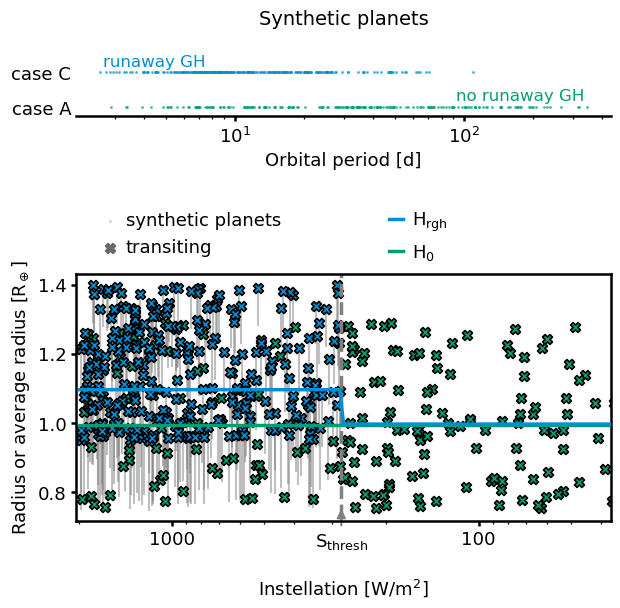

In [332]:
from HnullHmo import plot_HnullHmo, plot_transitingplanets, draw_Sthresh, plot_has_magmaocean

fig, (ax, ax2) = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1,4]}, figsize=[6.4,6.4])
ax = plot_has_magmaocean(sample.to_pandas().sample(min(500, len(sample)), random_state=42), ax)
ax2 = draw_Sthresh(ax2, planets_args)
ax2 = plot_transitingplanets(sample, planets_args, ax2, parameter_of_interest=parameter_of_interest)
# from matplotlib import rc
# rc('axes', linewidth=8)
# import plotstyle
ax2 = plot_HnullHmo(sample, planets_args, ax2, parameter_of_interest=parameter_of_interest)


# ax2.set_xlim(2050, 37)
# ax2.set_ylim(0.76, 1.4)
ax.set_title('Synthetic planets', y=1.35, fontsize=14)


#DEBUG
# plt.scatter(100, np.average(s[~s.has_magmaocean].R)) 
# plt.scatter(1000, np.average(s[s.has_magmaocean].R)) 


fig.tight_layout(h_pad=2.)


print('N_transiting: {}'.format(sample.to_pandas().transiting.sum()))

In [333]:
# fig.savefig(paths.static / "HnullHmo.pdf")

# Compute radius differences to inform hypotheses

The magma ocean hypotheses rely on measurements of average radii and bulk densities. Here, we create a table to inform the hypothesis function.

We take into account *only the transiting planets*, as these are the ones we'll be detecting (the radius differences of transiting planets differ on the percent level compared to using all planets).

-------
**This needs to be executed whenever:**
- file `avg_deltaR_deltaRho.csv` is not available
- stars or planets are generated from a different source (e.g. different occurrence rates)
- new biases/sample limits are introduced (e.g. minimum planet radius, transit depth, ...)

-------

This is slow (~10-20min if considering stellar evo).

In [334]:
# %%time
# from bioverse.hypothesis import compute_avg_deltaR_deltaRho
# avg_deltaR_deltaRho = compute_avg_deltaR_deltaRho(stars_args, planets_args)

# # reset star, planet args for use in this notebook
# stars_args, planets_args = get_generator_args()

# Survey simulation

We have generated a population of synthetic planets that orbit synthetic stars and we have injected a statistical trend originating from the presence of magma oceans on some planets. Only a subset of these planets "will be detectable by a transit or direct imaging survey. For those planets, only a subset of their properties can be directly probed, and only with a finite level of precision."

In the following, we will simulate a transit survey and try to detect the (population-wide) effect on the planet radius caused by global magma oceans

## Define transit survey

let's define some key parameters of the survey: [TODO: check which ones are needed to define our transit surveys]
- ``diameter``: the diameter of the telescope primary in meters (or the area-equivalent diameter for a telescope array)
- ``t_max``: maximum amount of time across which to combine transit observations, in days
- ``N_obs_max``: maximum allowable number of transit observations per target
- ``t_slew``: slew time between observations, in days
- ``D_ref``: diameter of the reference telescope, in meters

e.g., we could choose values similar to the ones expected for the LIFE telescope array (LIFE collaboration, 2021). In the nominal configuration with four 2 m telescopes, it would have a equivalent light-collecting area of a 4 m telescope.

In [335]:
survey = TransitSurvey(diameter=8.5, t_max=3652.5, t_slew=0.1, N_obs_max=1000)
# survey = TransitSurvey(diameter=.5, t_max=3.6525, t_slew=0.1, N_obs_max=2)

Created a new TransitSurvey


Let's add some measurements our survey conducts. 'small_radius' is True for a planet if it has a radius smaller than the mean of the population.

In [336]:
margs = {}
mkeys = ['L_st', 'R_st', 'M_st', 'T_eff_st', 'd', 'age', 'depth', 'R', 
         'T_dur', 'P', 'a', 'a_eff', 'S', 'S_abs',
         'M', 'rho']

# # GOOD survey: choose very optimistic values for now.
margs['precision'] = {'T_eff_st': 25.,
                      'R_st': '1%',
                      'depth': '1%',
                      'R': '2%',
                      'M_st': '1%',
                      'age': '30%',
                      'P': 0.000001,
                      'S': '5%',
                      'S_abs': '5%',
                      'M': '5%',
                      'rho': '7%'}

# # Mediocre survey 
# margs['precision'] = {'T_eff_st': 50.,
#                       'R_st': '5%',
#                       'depth': '5%',
#                       'R': '5%',
#                       'M_st': '10%',
#                       'age': '50%',
#                       'P': 0.00001,
#                       'S': '10%',
#                       'S_abs': '10%',
#                       'M': '10%',
#                       'rho': '15%'}

# # BAD survey: choose rather modest survey performance.
# margs['precision'] = {'T_eff_st': 75.,
#                       'R_st': '20%',
#                       'depth': '20%',
#                       'R': '25%',
#                       'M_st': '30%',
#                       'age': '75%',
#                       'P': 0.01,
#                       'S': '20%',
#                       'S_abs': '20%',
#                       'M': '5%',
#                       'rho': '30%'}



# Add the measurements to s_transit
for mkey in mkeys:
    kwargs = {}
    for key, vals in margs.items():
        if mkey in vals:
            kwargs[key] = vals[mkey]
    survey.add_measurement(mkey, **kwargs)
# survey

which planets are detectable?

In [337]:
detected = survey.compute_yield(sample)
N = len(detected)
print(N)

496


simulate observations, obtain dataset

In [338]:
data = survey.observe(detected, demographics=True)
# data.to_pandas().head()


/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


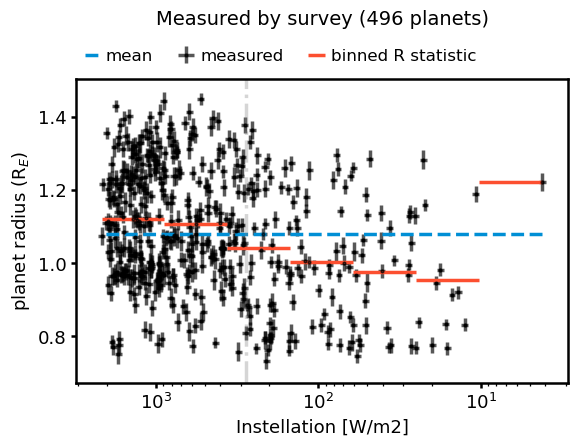

In [339]:
yvar = parameter_of_interest
xvar = 'S_abs'
# yvar = 'R' 

fig, ax = plt.subplots()
ax.scatter(data[xvar], data[yvar], s=2, c='k')
ax.errorbar(data[xvar], data[yvar], xerr=data.error[xvar], yerr=data.error[yvar], fmt='o', ms=2., 
            color='k', alpha=.66, label='measured')


ax.set_xscale('log')
# ax.set_yscale('log')


# plot binned stats as errorbar plot
means, edges, n, std = binned_stats(data, xvar, yvar, np.geomspace(np.min(data[xvar]), np.max(data[xvar]), num=8), statistic='mean')
ax.hlines(np.mean(data[yvar]), np.min(data[xvar]), np.max(data[xvar]), color='C2', ls='--', label='mean')
ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
           yerr=None, fmt='none', color='C1', label='binned {} statistic'.format(yvar), elinewidth=2.5)

if xvar == 'S_abs':
    ax.set_xlabel('Instellation [W/m2]')
    ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
    ax.invert_xaxis()

if yvar == 'R':
    ax.set_ylabel('planet radius (R$_E$)')
elif yvar == 'rho':
    ax.set_ylabel('bulk density(g/cm3)')
    
ax.set_title('Measured by survey ({} planets)'.format(N), y=1.15, fontsize=14)
fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.15, .97),
                              frameon=False, columnspacing=1.6)


# Hypothesis tests 

## Define Hypotheses

In [340]:
from bioverse.hypothesis import Hypothesis, magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 

if parameter_of_interest == 'R':
    labels = ('R',)
elif parameter_of_interest == 'rho':
    labels = ('rho',)
    
params = ('S_thresh', 'wrr', 'f_rgh', 'avg')
labels = (parameter_of_interest + '_mean',)    
features = ('a_eff',)

# define PRIORS for the parameters in theta (log-uniform for 'S_thresh' and 'wrr', uniform for 'f_rgh', 'R_avg')
log = (True, True, False, False)

if parameter_of_interest == 'R':
    bounds = np.array([[10., 1000.0], [1e-5, 0.1], [0.0, 1.0], [.1, 15.]])
elif parameter_of_interest == 'rho':
    bounds = np.array([[10., 1000.0], [1e-5, 0.1], [0.0, 1.0], [1., 6.]])
    


# interpolate average delta R/delta rho
avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() 
select_mechanisms = (avg_deltaR_deltaRho.gh_increase == planets_args['gh_increase']) & (
                    avg_deltaR_deltaRho.water_incorp == planets_args['water_incorp'])
f_dR = scipy.interpolate.interp1d(avg_deltaR_deltaRho[select_mechanisms].wrr,
                avg_deltaR_deltaRho[select_mechanisms]['delta_' + parameter_of_interest],
                fill_value='extrapolate')


# define hypothesis; define null hypothesis (a broad distribution in planet radius that is independent of orbital distance)
bounds_null = np.array([bounds[-1]])            # prior bounds for null hypothesis

if parameter_of_interest == 'R':
    h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'], 
                              simplified=planets_args['simplified'], diff_frac=radius_change, parameter_of_interest=parameter_of_interest, f_dR=f_dR)
    # h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(True,))
    h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(log[-1],))
    
    
    
elif parameter_of_interest == 'rho':
    h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                              simplified=planets_args['simplified'], diff_frac=density_change, parameter_of_interest=parameter_of_interest, f_dR=f_dR)
    # h_magmaocean = Hypothesis(magma_ocean_hypo_exp, bounds, params=params, features=features, labels=labels, log=log)
    h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('rho_avg_random',), features=features, labels=labels, log=(log[-1],))

show rolling mean of radius and density and their uncertainties

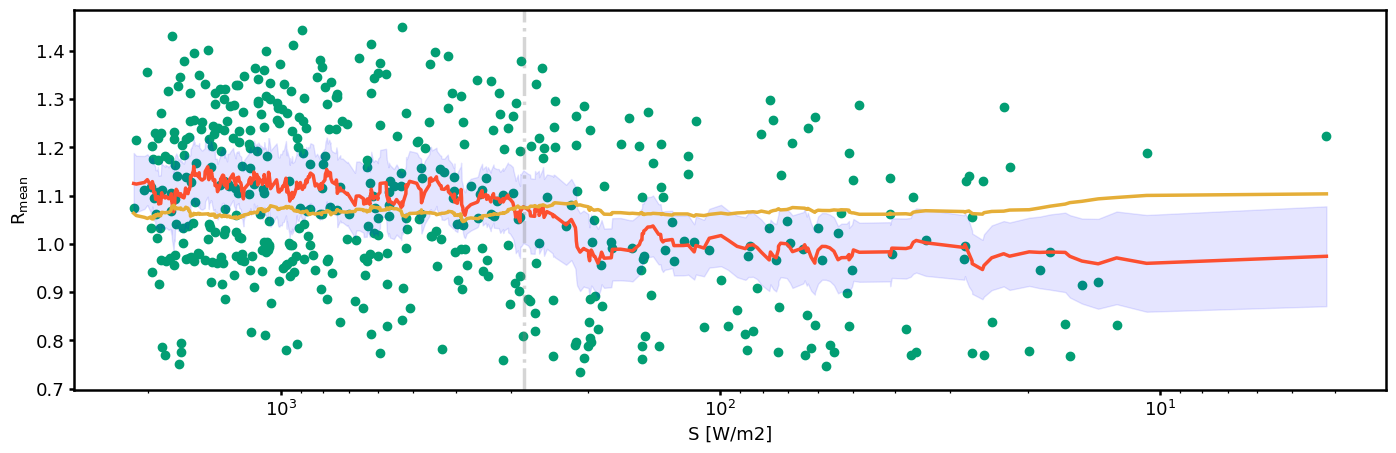

In [341]:
def plot_rolling_mean(data, parameter_of_interest='R'):
    """diagnostic plot"""
    fig, ax = plt.subplots(figsize=[16,5])
    ax.scatter(data['S_abs'], data[parameter_of_interest])
    ax.plot(data.sort_by('S_abs')['S_abs'], data.sort_by('S_abs')[parameter_of_interest +'_mean'], c='C1')
    mean = data.sort_by('S_abs')[parameter_of_interest + '_mean']
    sem = data.error.sort_by('S_abs')[parameter_of_interest + '_mean']
    ax.fill_between(data.sort_by('S_abs')['S_abs'], (mean-sem), (mean+sem), color='b', alpha=.1)
    ax.plot(data.sort_by('S_abs')['S_abs'], data.error[parameter_of_interest + '_mean'] + 1, c='C3')
    ax.set_ylabel(parameter_of_interest + '$_\mathrm{mean}$')
    ax.set_xlabel('S [W/m2]')
    ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
    ax.invert_xaxis()
    ax.set_xscale('log')

plot_rolling_mean(data, parameter_of_interest=parameter_of_interest)

## Perform hypothesis testing 

Sample posterior; Calculate the Bayesian evidence supporting h_magmaocean in favor of h_null from our simulated dataset.

The parameter space is complex, need to use nested sampling (not MCMC).

In [342]:
%%time
import corner

nburn = 10
nlive = 200

# Sample the posterior distribution of h(theta | x, y) using a simulated data set, and compare to the null hypothesis via a model comparison metric.
results = h_magmaocean.fit(data, return_chains=True, nburn=nburn, nlive=nlive, sampler_results=True)
# results = h_magmaocean.fit(data, return_chains=True, nburn=100, nlive=200, method='emcee')
 
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.3f})".format(
    results['dlnZ'], np.exp(-results['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 144.4 (corresponds to p = 0.000)
CPU times: user 6.92 s, sys: 302 ms, total: 7.22 s
Wall time: 6.53 s


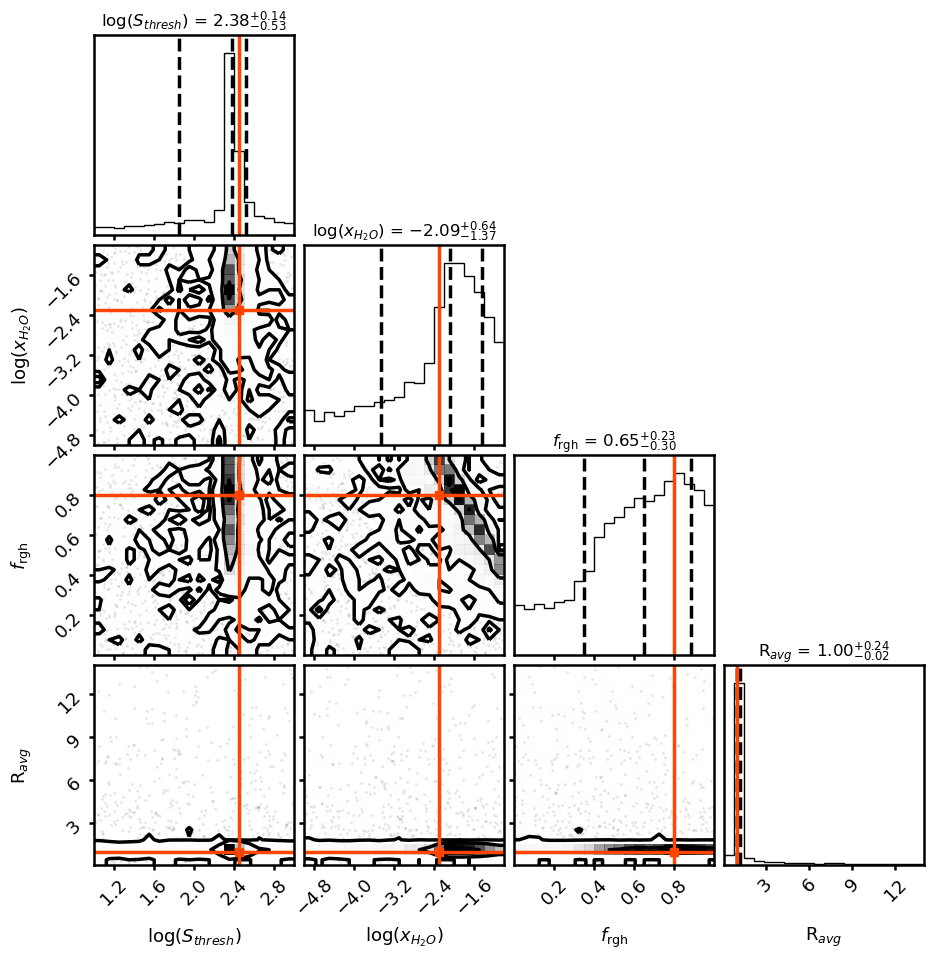

In [343]:
# plt.style.use('classic')sampler_resultsn into DataFrame, make logged columns for params with log priors
chains = pd.DataFrame(results['chains'], columns=params)
for p, l in zip(params, log):
    if l:
        chains['log_' + p] = np.log10(chains[p])
        
        
# compute truths
if parameter_of_interest == 'R':
    avg_out = np.average(sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])
elif parameter_of_interest == 'rho':
    avg_out = np.average(CONST['rho_Earth']*sample['M'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']]/
                         (sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])**3)
truths=np.array([np.log10(planets_args['S_thresh']), np.log10(planets_args['wrr']), planets_args['f_rgh'], avg_out])

fig = corner.corner(
                    # chains[['f_magma', 'log_a_cut', 'radius_reduction']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$'],
                    # chains[['f_magma', 'log_a_cut', 'lambda_a']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$\lambda_a$'],
                    # chains[['f_magma', 'log_a_cut', 'radius_reduction','R_avg']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$', 'R$_{avg}$'],
                    chains[['log_S_thresh', 'log_wrr', 'f_rgh', 'avg']], labels=['$\log(S_{thresh})$', '$\log(x_{H_2O})$', '$f_\mathrm{rgh}$', parameter_of_interest + '$_{avg}$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12},
                    truths=truths, truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['lambda_a']], truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['radius_reduction'], R_avg], truth_color='orangered'
                    )

fig.set_facecolor('white')

## Sampling diagnostics

In [344]:
# sampler_results = results['sampler_results']
# exp_truths = [10**t if l else t for t, l in zip(truths, log)]

# from dynesty import plotting as dyplot

# # Plot a summary of the run.
# rfig, raxes = dyplot.runplot(sampler_results)

# # Plot traces and 1-D marginalized posteriors.
# tfig, taxes = dyplot.traceplot(sampler_results, truths=exp_truths, truth_color='black', connect=True,
#                              connect_highlight=range(5))
# plt.tight_layout()

# # Plot the 2-D marginalized posteriors.
# cfig, caxes = dyplot.cornerplot(sampler_results, truths=exp_truths, truth_color='orangered')

show samples from the posterior

(2000, 40.0)

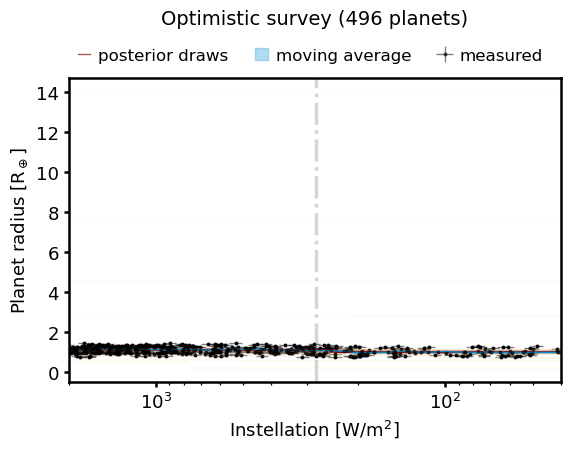

In [345]:
# %matplotlib widget

from bioverse.util import S2a_eff
yvar = parameter_of_interest
xvar = 'S_abs'
# yvar = 'R' 

fig, ax = plt.subplots()
ax.scatter(data[xvar], data[yvar], s=2, c='k')
ax.errorbar(data[xvar], data[yvar], xerr=data.error[xvar], yerr=data.error[yvar], fmt='o', ms=2., elinewidth=1, 
            color='k', alpha=.5, label='measured')

# overplot samples from the posterior
sampler_results = results['sampler_results']
posterior_sample = sampler_results.samples[nburn::100]

S_grid = np.geomspace(10., 2000., 300)
a_eff_grid = S2a_eff(S_grid)

colors = plt.cm.OrRd(np.linspace(0, 1, len(posterior_sample)))
for i, s in enumerate(posterior_sample):
    P_magma = magma_ocean_hypo((s[0], s[1], s[2], s[3]), a_eff_grid,
                               gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                               simplified=planets_args['simplified'], parameter_of_interest=parameter_of_interest)
    ax.plot(S_grid, P_magma, 
            c=colors[i],
            # c='k',
            alpha=.3, lw=1.)
ax.plot(S_grid, P_magma, 
        c=colors[i],
#         # c='k',
        alpha=.63, lw=1., label='posterior draws')
    
    
# # plot binned stats as errorbar plot
# means, edges, n, std = binned_stats(data, xvar, yvar, np.geomspace(np.min(data[xvar]), np.max(data[xvar]), num=12), statistic='mean')
# ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
#            yerr=None, fmt='none', color='C1', label='binned {} statistic'.format(yvar), elinewidth=2.5)


ax.set_xscale('log')
# ax.set_yscale('log')
if xvar == 'S_abs':
    ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]')
    ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
    ax.invert_xaxis()
if yvar == 'R':
    ax.set_ylabel('Planet radius [R$_\oplus$]')
elif yvar == 'rho':
    ax.set_ylabel('bulk density(g/cm3)')
    
    
# add confidence interval of rolling mean radius
mean = data.sort_by('S_abs')[parameter_of_interest + '_mean']
sem = data.error.sort_by('S_abs')[parameter_of_interest + '_mean']
ax.plot(data.sort_by('S_abs')['S_abs'], mean, 
                color='C2', lw=1)
ax.fill_between(data.sort_by('S_abs')['S_abs'], (mean-sem), 
                (mean+sem), color='C2', alpha=.3, label='moving average')


ax.set_title('Optimistic survey ({} planets)'.format(N), y=1.15, fontsize=14)
fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.15, .97),
                              frameon=False, columnspacing=1.6)

# ax.axhline(0.98, color='C2', ls='--', label='mean')

ax.set_xlim(2000,40.)
# ax.set_ylim(0.8, 1.4)
# ax.set_ylim(1.8, 5.)

In [346]:
# fig.savefig(paths.static / 'optimistic_R-S.pdf')

# Statistical Power
Test sensitivity on Poisson uncertainty, e.g. the specific realization of a survey.

In [347]:
from bioverse import analysis, plots

In [2]:
%%time
from bioverse import analysis, plots

d_grid = np.round(np.geomspace(30, 70, 8))
results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, d_max=d_grid, N=20, processes=8, **planets_args)

# Determine the statistical power assuming a significance threshold of dlnZ > 3
power = analysis.compute_statistical_power(results, method='dlnZ', threshold=3)
print("The statistical power of the survey is {:.1f}%".format(100*power))

NameError: name 'np' is not defined

In [186]:
# # plt.plot(S_thresh_grid, results['dlnZ'].mean(axis=-1), lw=5)
# # plt.plot(wrr_grid, results['dlnZ'].mean(axis=-1), lw=5)
# # plt.plot(d_grid, results['dlnZ'].mean(axis=-1), lw=5)
# plt.plot(results['N_pl'].mean(axis=-1), results['dlnZ'].mean(axis=-1), lw=3)

# percentiles = np.percentile(results['dlnZ'], [5., 95.], axis=1)    # 5% and 95% percentiles

# lns2 = plt.fill_between(results['N_pl'].mean(axis=-1),
#                      percentiles[0],
#                      percentiles[1],
#                      color=(0.45, 0.65, 0.9), alpha=.5,
#                      label="90% prediction interval")

# # plt.xlabel('S_thresh', fontsize=20)
# # plt.xlabel('water fraction', fontsize=20)
# # plt.xlabel('d_max', fontsize=20)
# plt.xlabel('Sample size $N_\mathrm{planets}$', fontsize=20)

# plt.ylabel('$\Delta$lnZ', fontsize=20)
# plt.axhline(3, lw=2, c='black', linestyle='dashed')
# plt.annotate('$\Delta$lnZ = 3', (220, 2), va='top', ha='right')
# # plt.xscale('log')
# plt.yscale('symlog')
# # plt.xlim(20, 50)
# # plt.ylim(1e-5, 20)

# # plt.loglog()
# plt.legend()

## statistical power grid
This is very slow: **up to 5h** for a grid of 8x8 and N=20

In [419]:
%%time
wrr_grid = [0., 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# wrr_grid = [0.0001, 0.005, 0.05]
f_rgh_grid = np.linspace(0., 1., len(wrr_grid))

reduced_args = {key: planets_args[key] for key in planets_args if (key != 'wrr') & (key != 'f_rgh')} # remove keys used in the grid
# results_grid = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, wrr=wrr_grid, f_rgh=f_rgh_grid, N=20, processes=8, **reduced_args)
results_grid = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, wrr=wrr_grid, f_rgh=f_rgh_grid,
                                             N=3, processes=8, return_chains=True, **reduced_args)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [42:54<00:00, 13.41s/it]

CPU times: user 550 ms, sys: 511 ms, total: 1.06 s
Wall time: 42min 54s


In [421]:
pickle.dump(results_grid, open(paperdatadir + 'bioverse_objects/optimistic_H2O-f-grid.pkl','wb'))

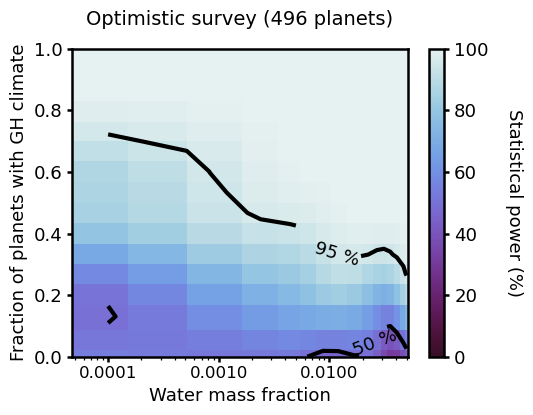

In [426]:
fig, ax = plt.subplots(figsize=[6,4])
labels= ('Water mass fraction', 'Fraction of planets with GH climate')
fig, ax = plots.plot_power_grid(results_grid, method='dlnZ', axes=('wrr', 'f_rgh'), labels=labels, 
                                log=(True, False), show=False, fig=fig, ax=ax, 
                                # zoom_factor=2, smooth_sigma=.5, 
                                zoom_factor=2, smooth_sigma=.7, 
                                levels=[20, 50, 95], cmap=cmocean.cm.dense_r)
# ax.set_xlim(wrr_grid[0]/2, 0.05)
ax.set_ylim(0., 1.)
ax.set_xlabel(labels[0], fontsize=13)
ax.set_ylabel(labels[1], fontsize=13)
ax.set_title('Optimistic survey ({} planets)'.format(N), y=1.05, fontsize=14)
ax.collections[0].colorbar.set_label('Statistical power [%]', fontsize=13) 

In [246]:
# fig.savefig(paths.static / 'optimistic_statpwr_H2O-f.pdf')

# PLATO
explore capability of the PLATO survey

In [348]:
plato = TransitSurvey()

margs = {}
mkeys = ['L_st', 'R_st', 'M_st', 'T_eff_st', 'd', 'age', 'depth', 'R', 
         'T_dur', 'P', 'a', 'a_eff', 'S', 'S_abs',
         'M', 'rho']
margs['precision'] = {'T_eff_st': 50.,
                      'R_st': '5%',
                      'depth': '0.005%', # Matuszewski et al., in prep., plato2017
                      'R': '3%', # Rauer2021
                      'M_st': '1%',
                      'age': '10%', # Rauer2021
                      'P': 0.00001,
                      'S': '10%',
                      'S_abs': '10%',
                      'M': '10%', # Rauer2021
                      'rho': '13.5%'} # error propagation from M, R errors.
for mkey in mkeys:
    kwargs = {}
    for key, vals in margs.items():
        if mkey in vals:
            kwargs[key] = vals[mkey]
    plato.add_measurement(mkey, **kwargs)

Created a new TransitSurvey


In [349]:
detected = plato.compute_yield(sample)
data_plato = plato.observe(detected, demographics=True)

results_plato = h_magmaocean.fit(data_plato, return_chains=True, nburn=nburn, 
                                 nlive=nlive, sampler_results=True)
 
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.3f})".format(
    results_plato['dlnZ'], np.exp(-results_plato['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 147.8 (corresponds to p = 0.000)


## stat. power of different survey designs
For several versions of PLATO, show $\Delta \ln Z (f_{rgh}$)

In [355]:
N_runs = 25   # number of randomized runs for each hypothesis grid point
num_grid = 12 # number of points in the grid
N_processes = 8

nominal PLATO

In [ ]:
%%time
reduced_args = {key: val for key, val in planets_args.items() if key != 'f_rgh'}

# f_grid = np.linspace(0., 1., 10)
f_grid = np.linspace(0., 1., num_grid)

res_fg_plato = analysis.test_hypothesis_grid(h_magmaocean, g_transit, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, 
                                        **reduced_args)
pwr_fg_plato = analysis.compute_statistical_power(res_fg_plato, method='dlnZ', threshold=3)
pickle.dump(res_fg_plato, open(paperdatadir + 'bioverse_objects/plato_f-grid.pkl','wb'))

  0%|                                                                                                                                                  | 0/300 [00:00<?, ?it/s]

a PLATO mission with a smaller sample size

In [307]:
%%time
g_100 = generate_generator(d_max=55)
res_fg_plato100 = analysis.test_hypothesis_grid(h_magmaocean, g_100, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, 
                                        **reduced_args)

g_40 = generate_generator(d_max=39)
res_fg_plato40 = analysis.test_hypothesis_grid(h_magmaocean, g_40, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, 
                                        **reduced_args)

pickle.dump(res_fg_plato100, open(paperdatadir + 'bioverse_objects/plato100_f-grid.pkl','wb'))
pickle.dump(res_fg_plato40, open(paperdatadir + 'bioverse_objects/plato40_f-grid.pkl','wb'))

Created a new Generator


100%|███████████████████████████████████████████████████████████████████████████| 300/300 [28:57<00:00,  5.79s/it]

Created a new Generator



100%|███████████████████████████████████████████████████████████████████████████| 300/300 [18:49<00:00,  3.76s/it]

CPU times: user 1.73 s, sys: 940 ms, total: 2.67 s
Wall time: 47min 47s


a PLATO mission with follow-up (bulk density-based hypothesis tests)
(have to redefine hypotheses) 

In [261]:

# interpolate average delta R/delta rho
avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() 
select_mechanisms = (avg_deltaR_deltaRho.gh_increase == planets_args['gh_increase']) & (
                    avg_deltaR_deltaRho.water_incorp == planets_args['water_incorp'])
f_dR_rho = scipy.interpolate.interp1d(avg_deltaR_deltaRho[select_mechanisms].wrr,
                avg_deltaR_deltaRho[select_mechanisms]['delta_rho'],
                fill_value='extrapolate')

h_magmaocean_rho = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                              simplified=planets_args['simplified'], diff_frac=density_change, parameter_of_interest='rho', f_dR=f_dR_rho)
h_magmaocean_rho.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('rho_avg_random',), features=features, labels=labels, log=(log[-1],))


res_fg_plato_rho = analysis.test_hypothesis_grid(h_magmaocean_rho, g_100, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, 
                                        **reduced_args)
pickle.dump(res_fg_plato_rho, open(paperdatadir + 'bioverse_objects/plato_rho_f-grid.pkl','wb'))

100%|█████████████████████████████████████████████████████████████████████████████| 48/48 [05:18<00:00,  6.64s/it]


a PLATO mission with only FGK / M stars

In [354]:
from bioverse.hypothesis import compute_avg_deltaR_deltaRho

# FGK
stars_kwargs = {'M_st_min': 0.562} # K7 star
stars_args_FGK, planets_args_FGK = get_generator_args()
for key, value in stars_kwargs.items():
        stars_args_FGK[key] = value
g_FGK = generate_generator(**stars_kwargs)
avg_deltaR_deltaRho_FGK = compute_avg_deltaR_deltaRho(stars_args_FGK, planets_args_FGK, savefile=False)
select_mechanisms = (avg_deltaR_deltaRho_FGK.gh_increase == planets_args_FGK['gh_increase']) & (
                    avg_deltaR_deltaRho_FGK.water_incorp == planets_args_FGK['water_incorp'])

for R_rho in ['R', 'rho']:
    f_dR_FGK = scipy.interpolate.interp1d(avg_deltaR_deltaRho_FGK[select_mechanisms].wrr,
                avg_deltaR_deltaRho_FGK[select_mechanisms]['delta_{}'.format(R_rho)],
                fill_value='extrapolate') 
    h_magmaocean_FGK = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                                  log=log, parameter_of_interest=R_rho, f_dR=f_dR_FGK)
    h_magmaocean_FGK.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(log[-1],))
    
    res_fg_plato_FGK = analysis.test_hypothesis_grid(h_magmaocean_FGK, g_FGK, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, 
                                        **reduced_args)
    pickle.dump(res_fg_plato_FGK, open(paperdatadir + 'bioverse_objects/plato_FGK_{}.pkl'.format('R_rho'),'wb')) 
    
    
# repeat for M stars
stars_kwargs = {'M_st_max': 0.562} # K7 star
stars_args_M, planets_args_M = get_generator_args()
for key, value in stars_kwargs.items():
        stars_args_M[key] = value
g_M = generate_generator(**stars_kwargs)
avg_deltaR_deltaRho_M = compute_avg_deltaR_deltaRho(stars_args_M, planets_args_M, savefile=False)
select_mechanisms = (avg_deltaR_deltaRho_M.gh_increase == planets_args_M['gh_increase']) & (
                    avg_deltaR_deltaRho_M.water_incorp == planets_args_M['water_incorp'])

for R_rho in ['R', 'rho']:
    f_dR_M = scipy.interpolate.interp1d(avg_deltaR_deltaRho_M[select_mechanisms].wrr,
                avg_deltaR_deltaRho_M[select_mechanisms]['delta_{}'.format(R_rho)],
                fill_value='extrapolate') 
    h_magmaocean_M = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                                  log=log, parameter_of_interest=R_rho, f_dR=f_dR_M)
    h_magmaocean_M.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(log[-1],))
    
    res_fg_plato_M = analysis.test_hypothesis_grid(h_magmaocean_M, g_M, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, 
                                        **reduced_args)
    pickle.dump(res_fg_plato_M, open(paperdatadir + 'bioverse_objects/plato_M_{}.pkl'.format(R_rho),'wb')) 

Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator

!!! The program failed at step 0: read_stars_Gaia !!!
!!! Returning incomplete simulation !!!


Traceback (most recent call last):
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 158, in generate
    d = self.steps[i].run(d,**kwargs)
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 236, in run
    return func(d,**kwargs2)
  File "/Users/schlecker/repos/Bioverse/bioverse/functions.py", line 150, in read_stars_Gaia
    d = luminosity_evolution(d)
  File "/Users/schlecker/repos/Bioverse/bioverse/functions.py", line 46, in luminosity_evolution
    df.at[i, 'L_st'] = tracks.loc[star_mass_bin].iloc[closest_age_id]['lum']
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 931, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1164, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", 

AttributeError: 'DataFrame' object has no attribute 'has_magmaocean'

**OR: Load previously saved objects:**

In [290]:
# ======================
objects = {'res_fg_plato': 'plato_f-grid.pkl', 'res_fg_plato100' : 'plato100_f-grid.pkl',
           'res_fg_plato40' : 'plato40_f-grid.pkl', 'res_fg_plato_rho' : 'plato_rho_f-grid.pkl'
           'res_fg_plato_FGK_R':'plato_FGK_R.pkl', 'res_fg_plato_FGK_rho':'plato_FGK_rho.pkl', # FGK vs M
           'res_fg_plato_M_R':'plato_FGK_M.pkl', 'res_fg_plato_M_rho':'plato_M_rho.pkl',} # FGK vs M
for varname, path in zip(objects.keys(),
    [paperdatadir + 'bioverse_objects/' + fname for fname in objects.values()]):
    with open(path, 'rb') as f:
        loaded_obj = pickle.load(f)
        exec(varname + '= loaded_obj') 
        

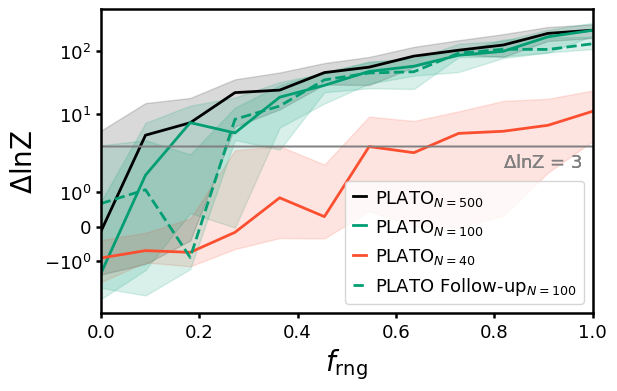

In [321]:
from scipy.interpolate import interp1d

def plot_plato_grids(f_grid, results, labels, yaxis='dlnZ', interpolate=False,
                     ci_percentiles=(16., 84.), fig=None, ax=None, **plot_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if yaxis == 'dlnZ':
        y_label = '$\Delta$lnZ'
        for i, (r, l) in enumerate(zip(results, labels)):
            y = r['dlnZ']
            y_mean = np.median(r['dlnZ'], axis=-1)
            percentiles = np.percentile(y, ci_percentiles, axis=1)    # 5% and 95% percentiles
            if interpolate:
                f_grid_fine = np.linspace(min(f_grid), max(f_grid), num=60)
                interpolate_grid = interp1d(f_grid, y_mean, kind='quadratic')
                y_mean = interpolate_grid(f_grid_fine)
                interpolate_p_lo = interp1d(f_grid, percentiles[0], kind='quadratic')
                interpolate_p_up = interp1d(f_grid, percentiles[1], kind='quadratic')
                percentiles = [interpolate_p_lo(f_grid_fine), interpolate_p_up(f_grid_fine)]
                x = f_grid_fine
            else:
                x = f_grid
                
            p = ax.plot(x, y_mean, lw=2, label=l, **plot_kwargs)
            lns2 = plt.fill_between(x,
                         percentiles[0],
                         percentiles[1],
                         alpha=.15, color=p[-1].get_color())
            
    elif yaxis == 'power':
        y_label = 'Statistical power [%]'
        for i, (r, l) in enumerate(zip(results, labels)):
            ax.plot(f_grid, np.array(r)*100, lw=2, c='C{}'.format(i),
                    label=l)
            
    ax.set_xlabel('$f_\mathrm{rng}$', fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.axhline(3, lw=1, c='gray', linestyle='-')
    ax.annotate('$\Delta$lnZ = 3', (.98, 2.3), va='top', ha='right', c='gray')
     # plt.xscale('log')
    ax.set_yscale('symlog')
    ax.set_xlim(0, 1)
    # # plt.ylim(1e-5, 20)
    ax.legend()
    return fig, ax

fig, ax = plot_plato_grids(f_grid, [res_fg_plato], 
                           ['PLATO$_{N=500}$'],
                           interpolate=False, c='k')

fig, ax = plot_plato_grids(f_grid, [res_fg_plato100, res_fg_plato40], 
                           ['PLATO$_{N=100}$', 'PLATO$_{N=40}$'],
                           interpolate=False, fig=fig, ax=ax)

fig, ax = plot_plato_grids(f_grid, [res_fg_plato_rho], 
                           ['PLATO Follow-up$_{N=100}$'],
                           # ['PLATO'],
                           interpolate=False, ci_percentiles=(16,84.), 
                           fig=fig, ax=ax, linestyle='--', c='C0')

In [305]:
# fig.savefig(paths.static / 'plato_fgrid.pdf')

## FGK vs. M



In [ ]:
res_fg_plato_FGK_R, res_fg_plato_FGK_rho, res_fg_plato_M_R, res_fg_plato_M_rho 

## grid of $S_{thresh}$ constraints
for different survey modes, compare the constraints on  $S_{thresh}$.
Plot posteriors from random draws of simulations.

/Users/schlecker/repos/magmaocean/src/scripts/plato_Sthresh_grid.py:24: UserWarning: which value of 'f_rgh' should be plotted? assuming f_rgh = 0.0
  
/Users/schlecker/repos/magmaocean/src/scripts/plato_Sthresh_grid.py:24: UserWarning: which value of 'f_rgh' should be plotted? assuming f_rgh = 0.0
  
/Users/schlecker/repos/magmaocean/src/scripts/plato_Sthresh_grid.py:24: UserWarning: which value of 'f_rgh' should be plotted? assuming f_rgh = 0.0
  
/Users/schlecker/repos/magmaocean/src/scripts/plato_Sthresh_grid.py:24: UserWarning: which value of 'f_rgh' should be plotted? assuming f_rgh = 0.0
  
/Users/schlecker/repos/magmaocean/src/scripts/plato_Sthresh_grid.py:24: UserWarning: which value of 'f_rgh' should be plotted? assuming f_rgh = 0.0
  
/Users/schlecker/repos/magmaocean/src/scripts/plato_Sthresh_grid.py:24: UserWarning: which value of 'f_rgh' should be plotted? assuming f_rgh = 0.0
  


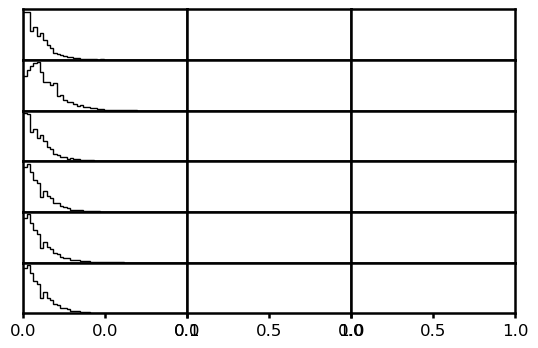

In [390]:
from plato_Sthresh_grid import plot_plato_Sthresh_grid, plot_posterior_hist

fig, axs = plt.subplots(nrows=6, ncols=3, gridspec_kw = {'wspace':0, 'hspace':0})

for i, ax in enumerate(axs[:,0]):
    plot_posterior_hist(results_grid, fig=fig, ax=ax, wrr=wrr_grid[1], seed=i)
    
    
# eye candy
for ax in axs.flatten():
    ax.tick_params(left = False, right = False , labelleft = False ,
                       labelbottom = False, bottom = False)
for ax in axs[-1,:]:
    ax.tick_params(labelbottom = True, bottom = True) 